In [1]:
import chess

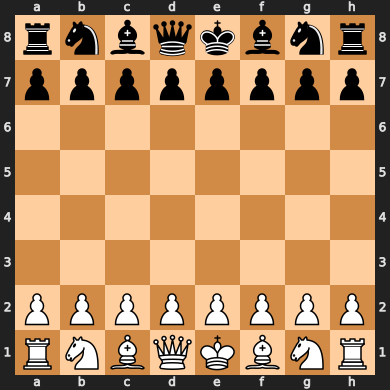

In [2]:
board = chess.Board()
board

In [5]:
import badgyal

bg = badgyal.BGNet(cuda=True)
board = chess.Board()

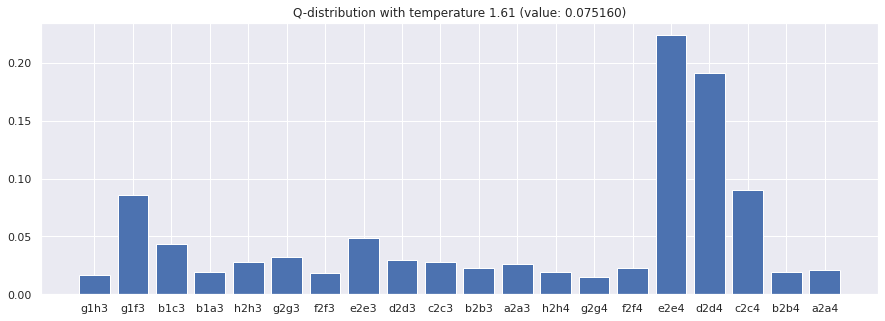

In [6]:
policy, value = bg.eval(board, softmax_temp=1.61)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

plt.figure(figsize=(15, 5))
plt.bar(policy.keys(), policy.values())
plt.title(f'Q-distribution with temperature 1.61 (value: {value:3f})')
plt.show()

In [7]:
a = max(policy, key=policy.get)
board.push(chess.Move.from_uci(a))

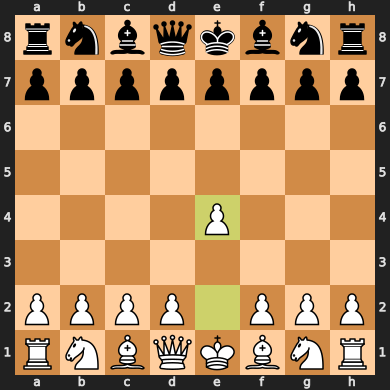

In [8]:
board

In [84]:
import gym_chess
import gym

In [10]:
env = gym.make('Chess-v0')
state = env.reset()
type(state)

chess.Board

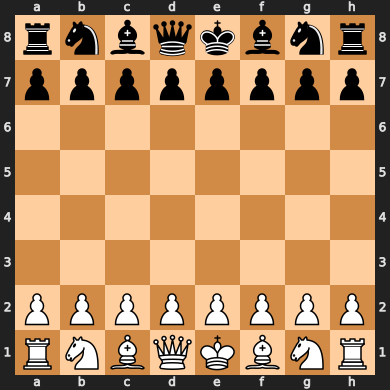

In [21]:
state

In [26]:
import random
next_state, *_ = env.step(random.choice(env.legal_moves))

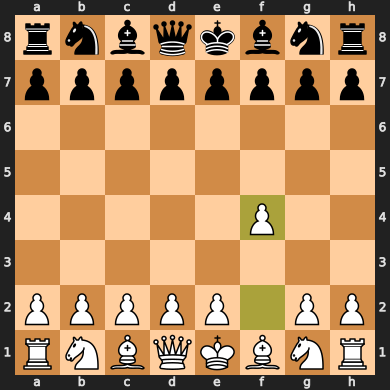

In [27]:
next_state

In [28]:
env.legal_moves

[Move.from_uci('g8h6'),
 Move.from_uci('g8f6'),
 Move.from_uci('b8c6'),
 Move.from_uci('b8a6'),
 Move.from_uci('h7h6'),
 Move.from_uci('g7g6'),
 Move.from_uci('f7f6'),
 Move.from_uci('e7e6'),
 Move.from_uci('d7d6'),
 Move.from_uci('c7c6'),
 Move.from_uci('b7b6'),
 Move.from_uci('a7a6'),
 Move.from_uci('h7h5'),
 Move.from_uci('g7g5'),
 Move.from_uci('f7f5'),
 Move.from_uci('e7e5'),
 Move.from_uci('d7d5'),
 Move.from_uci('c7c5'),
 Move.from_uci('b7b5'),
 Move.from_uci('a7a5')]

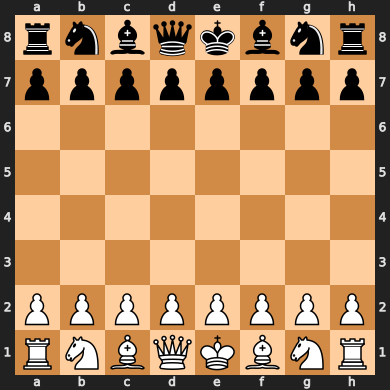

In [12]:
env = ChessVsRandom()
env.reset()

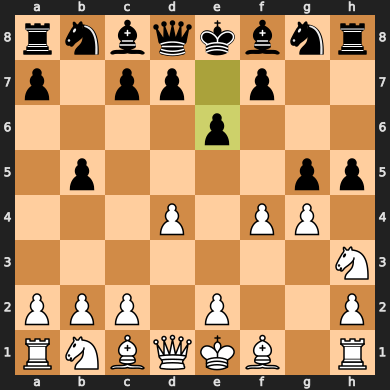

In [27]:
import random
env.step(random.choice(env.legal_moves))
env._board

## Stockfish

In [43]:
import chess
import chess.engine


engine = chess.engine.SimpleEngine.popen_uci(
    "./stockfish/stockfish_15_x64_avx2"  # TODO: fix stockfish installation
)

result = engine.play(board, chess.engine.Limit(time=0.1))
result.move

## Setting-up Chess Meta-Environment

In [1]:
from mlrl.meta.search_tree import SearchTree
from mlrl.meta.meta_env import MetaEnv
from mlrl.chess.chess_env import ChessVsRandom
from mlrl.chess.chess_state import ChessState, ChessQFunction

import badgyal


env = ChessVsRandom()
env.reset()

chess_network = badgyal.BGNet(cuda=True)
q_hat = ChessQFunction(chess_network)
initial_tree = SearchTree(env, ChessState.extract_state(env), q_hat)
meta_env = MetaEnv(env, initial_tree, max_tree_size=10)

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
from tf_agents.environments.tf_py_environment import TFPyEnvironment
from tf_agents.environments.gym_wrapper import GymWrapper

tf_meta_env = TFPyEnvironment(GymWrapper(meta_env))

In [8]:
tf_meta_env.action_spec()

BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(50))

In [3]:
from mlrl.utils.render_utils import embed_mp4, create_policy_eval_video
from mlrl.meta.meta_env import mask_invalid_action_constraint_splitter 
from tf_agents.policies.random_tf_policy import RandomTFPolicy

random_policy = RandomTFPolicy(tf_meta_env.time_step_spec(), tf_meta_env.action_spec(),
                               observation_and_action_constraint_splitter=mask_invalid_action_constraint_splitter)

In [9]:
embed_mp4(create_policy_eval_video(random_policy, tf_meta_env))

In [44]:
def run_episode(env, policy, max_steps=1000):
    time_step = env.reset()
    episode_return = 0.0
    for step in range(max_steps):
        action_step = policy.action(time_step)
        time_step = env.step(action_step.action)
        episode_return += time_step.reward
        if time_step.is_last():
            print(step)
            break

    return episode_return, time_step

In [45]:
episode_return, time_step = run_episode(tf_meta_env, random_policy)
episode_return, time_step

79


(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.0187691], dtype=float32)>,
 TimeStep(
 {'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
  'observation': OrderedDict([('search_tree_tokens',
                               <tf.Tensor: shape=(1, 10, 144), dtype=float32, numpy=
 array([[[ 0.        ,  0.        ,  0.        , ..., -0.6157869 ,
           0.03427959,  0.01362703],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         ...,
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ]]], dtype=float32)>),
                       

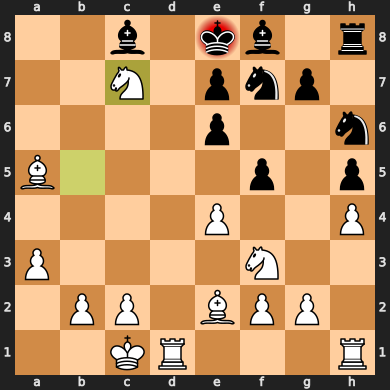

In [47]:
env

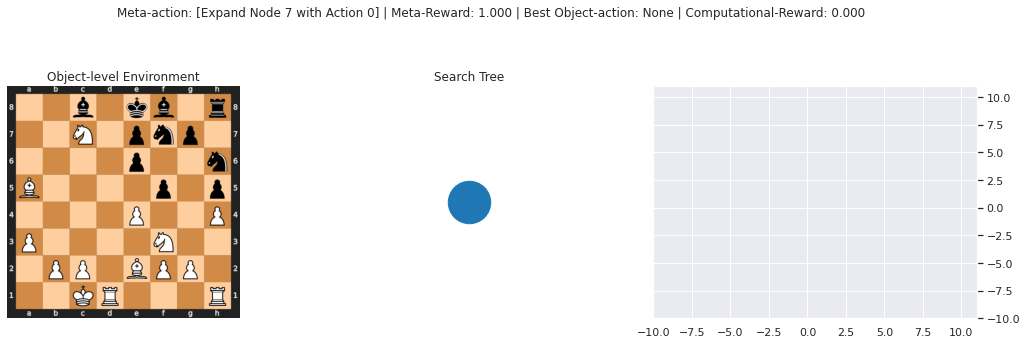

In [48]:
meta_env.render(plt_show=True);

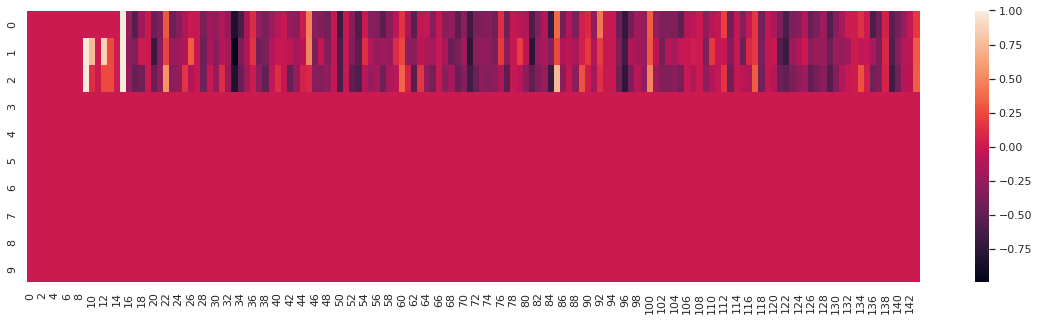

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

plt.figure(figsize=(20, 5))
sns.heatmap(observation['search_tree_tokens']);

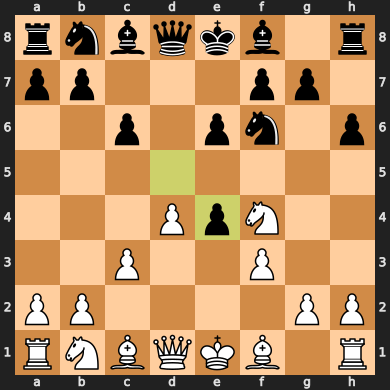

In [1]:
from mlrl.chess.chess_env import ChessVsSimpleNetwork
from IPython.display import clear_output, display
import chess


env = ChessVsSimpleNetwork()
env.reset()

try:
    while True:
        display(env._board)
        action = input('Enter action: ')
        observation, reward, done, info = env.step(chess.Move.from_uci(action))
        if done:
            break
        clear_output(wait=True)

except KeyboardInterrupt:
    pass

## First Trained Agent

In [1]:
from mlrl.experiments.utils import create_dqn_agent
from mlrl.meta.search_tree import SearchTree
from mlrl.meta.meta_env import MetaEnv
from mlrl.meta.search_q_model import SearchQModel
from mlrl.chess.chess_env import ChessVsRandom
from mlrl.chess.chess_state import ChessState, ChessQFunction

from tf_agents.environments.tf_py_environment import TFPyEnvironment
from tf_agents.environments.gym_wrapper import GymWrapper

import badgyal

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
object_env = ChessVsRandom()
object_env.reset()

chess_network = badgyal.BGNet(cuda=True)
q_hat = ChessQFunction(chess_network)
initial_tree = SearchTree(object_env, ChessState.extract_state(object_env), q_hat)
meta_env = MetaEnv(object_env, initial_tree, max_tree_size=10)
tf_env = TFPyEnvironment(GymWrapper(meta_env))

q_net = SearchQModel(head_dim=32)
agent = create_dqn_agent(tf_env, q_net)

INFO:tensorflow:Assets written to: ram://21c32111-6ab4-4a6c-bedd-dcfae95962a7/assets


INFO:tensorflow:Assets written to: ram://21c32111-6ab4-4a6c-bedd-dcfae95962a7/assets


In [3]:
search_tokens = tf_env.current_time_step().observation['search_tree_tokens']
q_net(search_tokens)

<tf.Tensor: shape=(1, 51), dtype=float32, numpy=
array([[-0.39271837, -0.02308892, -0.02501212, -0.02523614, -0.00049409,
        -0.00775333, -0.10888202, -0.10888202, -0.10888202, -0.10888202,
        -0.10888202, -0.10888202, -0.10888202, -0.10888202, -0.10888202,
        -0.10888202, -0.10888202, -0.10888202, -0.10888202, -0.10888202,
        -0.10888202, -0.10888202, -0.10888202, -0.10888202, -0.10888202,
        -0.10888202, -0.10888202, -0.10888202, -0.10888202, -0.10888202,
        -0.10888202, -0.10888202, -0.10888202, -0.10888202, -0.10888202,
        -0.10888202, -0.10888202, -0.10888202, -0.10888202, -0.10888202,
        -0.10888202, -0.10888202, -0.10888202, -0.10888202, -0.10888202,
        -0.10888202, -0.10888202, -0.10888202, -0.10888202, -0.10888202,
        -0.10888202]], dtype=float32)>

In [4]:
q_net.summary()

Model: "search_q_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  14592     
                                                                 
 prepend_terminate_token (Pr  multiple                 0         
 ependTerminateToken)                                            
                                                                 
 prepend_terminate_mask (Pre  multiple                 0         
 pendTerminateMask)                                              
                                                                 
 transformer (Transformer)   multiple                  43904     
                                                                 
 transformer_1 (Transformer)  multiple                 43904     
                                                                 
 to_q_vals (Sequential)      (None, 51)             

In [67]:
from official.nlp.modeling.layers.position_embedding import RelativePositionEmbedding

In [71]:
position_embedding = RelativePositionEmbedding(hidden_size=16)

In [95]:
import numpy as np

def positional_encoding(k, d, n=10000):
    P = np.zeros((d,))
    for i in np.arange(int(d/2)):
        denominator = np.power(n, 2*i/d)
        P[2*i] = np.sin(k/denominator)
        P[2*i + 1] = np.cos(k/denominator)
    return P

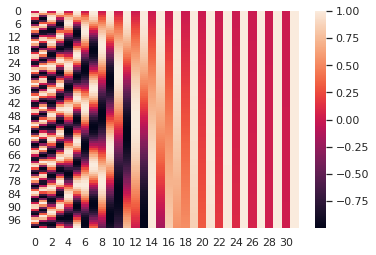

In [99]:
sns.heatmap([
    positional_encoding(k, 32, n=10000)
    for k in meta_env.tree.node_list
]);

<AxesSubplot:>

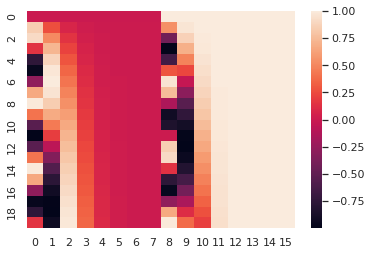

In [77]:
sns.heatmap(position_embedding(tf.ones((1, 20))))

In [10]:
search_tokens = tf_env.current_time_step().observation['search_tree_tokens']
q_net(search_tokens)

<tf.Tensor: shape=(1, 51), dtype=float32, numpy=
array([[0.02911164, 0.06965096, 0.06634165, 0.06706454, 0.06482331,
        0.05927221, 0.02911164, 0.02911164, 0.02911164, 0.02911164,
        0.02911164, 0.02911164, 0.02911164, 0.02911164, 0.02911164,
        0.02911164, 0.02911164, 0.02911164, 0.02911164, 0.02911164,
        0.02911164, 0.02911164, 0.02911164, 0.02911164, 0.02911164,
        0.02911164, 0.02911164, 0.02911164, 0.02911164, 0.02911164,
        0.02911164, 0.02911164, 0.02911164, 0.02911164, 0.02911164,
        0.02911164, 0.02911164, 0.02911164, 0.02911164, 0.02911164,
        0.02911164, 0.02911164, 0.02911164, 0.02911164, 0.02911164,
        0.02911164, 0.02911164, 0.02911164, 0.02911164, 0.02911164,
        0.02911164]], dtype=float32)>

In [5]:
from mlrl.utils.render_utils import embed_mp4, create_policy_eval_video

embed_mp4(create_policy_eval_video(agent.policy, tf_env, max_steps=300))

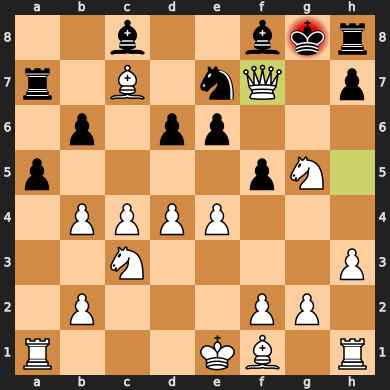

In [9]:
object_env

In [11]:
from mlrl.utils.render_utils import embed_mp4, create_policy_eval_video
from mlrl.meta.meta_env import mask_invalid_action_constraint_splitter 
from tf_agents.policies.random_tf_policy import RandomTFPolicy

random_policy = RandomTFPolicy(tf_env.time_step_spec(), tf_env.action_spec(),
                               observation_and_action_constraint_splitter=mask_invalid_action_constraint_splitter)

embed_mp4(create_policy_eval_video(random_policy, tf_env))